<a href="https://colab.research.google.com/github/olyaee/Mnist/blob/master/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 1.  [Introduction](#1)
    * 1.1. [Import Libraries](#2)
* 2. [Load, Train and Test data](#3)
    * 2.1. [Reshape input](#4)
    * 2.2. [One Hot encoding of labels](#5)
    * 2.3 [Data Visualization](#6)
* 3. [Preprocessing the digit images](#7)
    * 3.1. [Data Normalization](#8)
* 4. [Create Models](#10)
* 5. [Optimizer-Learning Rate-Data Augmentation](#11)
* 6. [Compile Model](#12)
* 7. [Results](#13)
    * 7.1. [Store the history](#14)
    * 7.2. [Create output file](#14)

    

<a id="1"></a> <br>
**1. Introduction**
===============================


<a id="2"></a> <br>
*1.1. Import Libraries*
-----------------------------
As the first step, we need to import needed libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Input
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, average, GlobalAveragePooling2D
from keras.layers import PReLU, add, AveragePooling2D, UpSampling3D, Dropout, Activation
from keras.models import Model, load_model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from IPython.display import Image
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
import pickle

print(os.listdir("./"))


['.config', 'drive', 'sample_data']


Using TensorFlow backend.


<a id="3"></a> <br>
**2. Load, Train and Test data**
============================
In order to load the data we used pandas library.
I have stored the data in my google drive. there are some othere ways to load data. For example you can directly import data from keras. 
Since we want to have the same train and validation data for every model we have done data sepration it in a seprate notebook and have stored the results as pickle file.
For the code you can refer to this [LINK](https://github.com/olyaee/Mnist/blob/master/data_split.ipynb)


In [4]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER_PATH = "./drive/My Drive/Colab Notebooks/vgg16/"
DATA_PATH = './drive/My Drive/Colab Notebooks/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with open(DATA_PATH+'x_train.pkl', 'rb') as input:
  x_train = pickle.load(input)
with open(DATA_PATH+'x_val.pkl', 'rb') as input:
  x_val = pickle.load(input)
with open(DATA_PATH+'y_train.pkl', 'rb') as input:
  y_train = pickle.load(input)
with open(DATA_PATH+'y_val.pkl', 'rb') as input:
  y_val = pickle.load(input)
with open(DATA_PATH+'x_test.pkl', 'rb') as input:
  x_test = pickle.load(input)

print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_val',y_train.shape)
print('y_val',y_val.shape)
print('x_test',x_test.shape)


x_train (37800, 784)
x_val (4200, 784)
x_val (37800,)
y_val (4200,)
x_test (28000, 784)


<a id="4"></a> <br>
*2.1. Reshape input*
-----------------------------

In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_val = x_val.reshape(x_val.shape[0], 28, 28,1)
print(x_train.shape)
print(x_val.shape)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
print(x_test.shape)

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(28000, 28, 28, 1)


<a id="5"></a> <br>
*2.2. One Hot encoding of labels*
-----------------------------
we have a number for each image but we need an array.
2 has to be converted to [0, 0, 1, 0, 0 ,0 ,0 ,0 ,0 ,0] 

In [7]:
y_train= to_categorical(y_train)
y_val= to_categorical(y_val)
num_classes = y_train.shape[1]
print(y_train.shape)

(37800, 10)


<a id="6"></a> <br>
*2.3 Data Visualization*
-----------------------------
Lets look at 3 images from data set with their labels.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


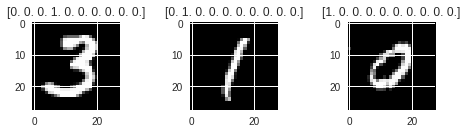

In [8]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

<a id="7"></a> <br>
**3. Preprocessing the digit images**
==================================


<a id="8"></a> <br>
*3.1. Data Normalization*
-----------------------------


In [0]:
# Normalize the data
x_train = x_train / 255.0
x_val = x_val / 255
x_test = x_test / 255.0

<a id="10"></a> <br>
**4. Create Model**
============================

The followin image is just for demonstration. for a detailed graph please look. at the saved image of the model. 





![](https://www.researchgate.net/profile/Saikat_Roy9/publication/322787849/figure/fig1/AS:588338117488642@1517282146532/VGG16-Architecture-with-Softmax-layer-replaced-used-as-the-base-model-for-each-classifier.png)

In [0]:
def two_conv_pool(x, F1, F2, name):
    x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

    return x

def three_conv_pool(x, F1, F2, F3, name):
    x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(F3, (3, 3), activation=None, padding='same', name='{}_conv3'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

    return x

vgg16_input = Input(shape = (28,28,1), dtype='float32', name='m2input')

net = two_conv_pool(vgg16_input, 64, 64, "block1")
net = two_conv_pool(net, 128, 128, "block2")
net = three_conv_pool(net, 256, 256, 256, "block3")
net = three_conv_pool(net, 512, 512, 512, "block4")

net = Flatten()(net)
net = Dense(512, activation='relu', name='fc')(net)
prediction_vgg16 = Dense(10, activation='softmax', name='predictions')(net)

 <a id="11"></a> <br>
**5. Optimizer-Learning Rate-Data Augmentation**
============================

In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [0]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)


<a id="12"></a> <br>
**6. Compile Model**
============================

In [14]:
# this is the model we will train
vgg16_model = Model(inputs=vgg16_input, outputs=prediction_vgg16)
vgg16_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#plot the model
plot_model(vgg16_model, to_file=FOLDER_PATH+'vgg16_model.png')
Image(filename=FOLDER_PATH+'vgg16_model.png', width=200, height=200, unconfined=True)

model_checkpoint = ModelCheckpoint(FOLDER_PATH+'vgg16_model.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

vgg16_history = vgg16_model.fit_generator(datagen.flow(x_train,y_train, batch_size=256),
                                            validation_data=(x_val, y_val),
                                            shuffle=True,
                                            epochs=70, 
                                            steps_per_epoch=len(x_train) / 256,
                                            callbacks=[learning_rate_reduction, model_checkpoint])

Epoch 1/70
148/147 [==============================] - 36s 246ms/step - loss: 2.2991 - acc: 0.3470 - val_loss: 14.5140 - val_acc: 0.0995
Epoch 2/70
148/147 [==============================] - 29s 199ms/step - loss: 0.3705 - acc: 0.8915 - val_loss: 7.5880 - val_acc: 0.3286
Epoch 3/70
148/147 [==============================] - 29s 199ms/step - loss: 0.1739 - acc: 0.9526 - val_loss: 0.5202 - val_acc: 0.9271
Epoch 4/70
148/147 [==============================] - 29s 199ms/step - loss: 0.1119 - acc: 0.9691 - val_loss: 0.9623 - val_acc: 0.8636
Epoch 5/70
148/147 [==============================] - 29s 199ms/step - loss: 0.0847 - acc: 0.9763 - val_loss: 0.3307 - val_acc: 0.9571
Epoch 6/70
148/147 [==============================] - 30s 199ms/step - loss: 0.0729 - acc: 0.9807 - val_loss: 0.1183 - val_acc: 0.9819
Epoch 7/70
148/147 [==============================] - 30s 199ms/step - loss: 0.0684 - acc: 0.9825 - val_loss: 0.2939 - val_acc: 0.9588
Epoch 8/70
148/147 [==============================] - 

<a id="13"></a> <br>
**7. Results**
============================

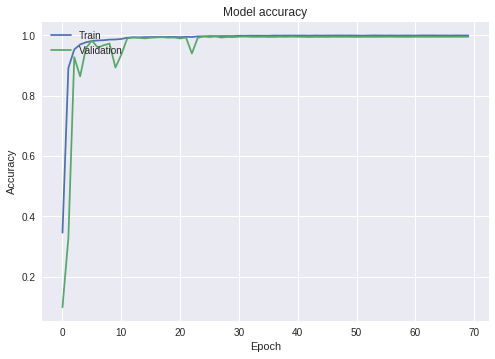

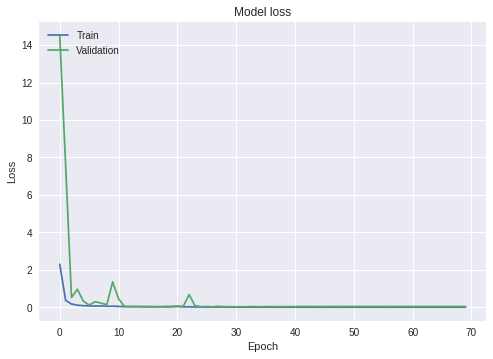

In [15]:
# Plot training & validation accuracy values
plt.plot(vgg16_history.history['acc'])
plt.plot(vgg16_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id="14"></a> <br>
*7.1. Store the history*
-----------------------------


In [0]:
with open(FOLDER_PATH+'vgg16_history.pkl', 'wb') as output:
  pickle.dump(vgg16_history, output, pickle.HIGHEST_PROTOCOL)


<a id="14"></a> <br>
*7.2. Create output file*
-----------------------------


In [17]:
model = load_model(FOLDER_PATH+'vgg16_model.hdf5')
output = np.array(model.predict(x_test))
#from categorial to a number. [0,0,0,0,0,0,1,0,0,0]->6
output = np.argmax(output,axis=1)
print(output)
np.savetxt(FOLDER_PATH+'vgg16_output.csv', output, delimiter=",",fmt='%d')


[2 0 9 ... 3 9 2]
